In [130]:
%load_ext autoreload
%autoreload 2

In [131]:
import cProfile
import time
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.datasets import make_blobs
from tqdm import tqdm_notebook

from hcluster.singlelink import SingleLinkClust
from hcluster.hierarchy import mst_linkage, linkage_naive, _mst_linkage_core
from hcluster.utils import pairwise_dist

In [11]:
def scipy_linkage(df, n_clust):
    linkage_matrix = linkage(df)
    labels = fcluster(linkage_matrix, n_clust, criterion="maxclust")
    
    return labels

# Описание алгоритма

За основу взята статья [“Modern hierarchical, agglomerative clustering algorithms”](https://arxiv.org/abs/1109.2378v1)

Вначале отдельно стоит обозначить в каком виде алгоритм принимает данные и возвращает.

**На вход**: матрица попарных расстояний размера N^2  
**На выход**: дендограмма Z размера (N - 1, 4). Подробное описание того, как она устроена можно найти в статье или в документации scipy/sklearn.

>A (n-1) by 4 matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i. A cluster with an index less than n corresponds to one of the original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

### Наивный

Итеративное описание алгоритма иерархической кластеризации достаточно простое для понимания, а также не зависит от выбранной метрики расстояния. Основная идея состоит в том, чтобы пройтись по всем примерам в матрице расстояний (ее нужно посчитать заранее), на каждой итерации найти два ближайщих - это новый кластер. Далее необходимо исключить из матрицы расстояний строки (и столбцы т.к она симметрична) для этих кластеров и добавить новую, посчитав расстояния от этого кластера до остальных. Закончить когда все точки окажутся в одном кластере. 

В статье предлагается каждому наблюдению отдельно сопоставить индекс, однако в данном случае это не нужно т.к за место него можно использовать индекс в матрице расстояний. За счет того, что нам необходимо обязательно пройтись один раз по всем данным и для каждого раза нужно искать минимум в матрице $(N, N)$, сложность получится $O(n^3)$. Так как надо еще хранить матрицу расстояний, то $О(n^2)$ по памяти.

Однако у такого подхода есть очевидные проблемы:

1. Обновлять матрицу расстояний очень дорого, особенно если учесть, что в numpy она неизменяема. Поэтому для работы алгоритма необходимо создавать матрицу размера $2*N - 1$. Однако в таком случае поиск минимума займет еще больше времени. Для решения проблемы можно переиспользовать изначальную матрицу, в этом случае на выходе получется неотсортированная дендограмма, где будет указана последовательность слияния кластеров по точкам им принадлежащим.
2. Поиск минимума в квадратной матрице занимает основную часть времени работы алгоритма. 


Ниже приведен псевдокод из статьи.

![naive](img/primitive.png)

### Эффективный

Данный алгоритм основан на наблюдении о том, что single linkage кластеризация похожа на проблему поиска минимального остовного дерева графа. 

> The algorithm here was originally described by Rohlf (1973) and is based on Prim’s algorithm for the MST (see Cormen et al., 2009, § 23.2).

Основная идея в том, чтобы вначале выбрать какую-то точку, найти для нее минимум, обьединить их в кластер. Повторить для найденной точки.
В таком случае поиск минимума занимает только $O(N)$. Также нет необходимости обновлять матрицу расстояний, а значит и хранить ее копию. Поэтому данный алгоритм наиболее эффективный в плане использования памяти из всех 3 предложенных в статье. В статье его также называют наиболее эффективным для случае singe linkage. Существует так же SLINK алгоритм для single linkage, основное преимущество которого в том, что он может читать матрицу расстояний строчка за строчкой, что важно при данных не помещяющихся в памяти. Однако в новых версиях scipy от него отказались.

Так как слияние кластеров происходит не последовательно по увеличению расстояния, итоговую дендограмму необходимо отсортировать по расстояниям, чтобы получить правильную последовательность от меньших кластеров к большим. Такеже необходимо присовить кластерам уникальные номера, в scipy стандартом считается нумеровать от $N$ до $2*N - 2$. Для этого используется find-union концепция, которая позволяет определить к какому кластеру принадлежит та или иная точка. 

Псевдокод уже для эффективной реализации.

![mst](img/mst_link.png)

# Проверка корректности работы

Проверим на простом примере сравнив с результатом работы алгоритма из scipy. Т.к в задание не входил какой-то подробный анализ с метриками, я решил ограничиться этим.

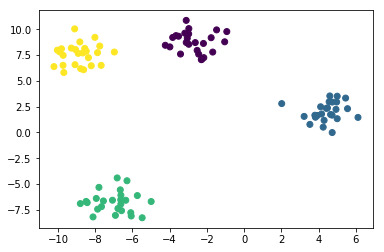

In [132]:
data, y = make_blobs(n_samples=100, n_features=2, centers=4, random_state=42)
plt.scatter(data[:, 0], data[:, 1], c=y)

In [133]:
scipy_labels = scipy_linkage(data, 4)
naive = SingleLinkClust()
mst = SingleLinkClust(method="mst")

In [134]:
naive_labels = naive.fit_predict(data, 4)
mst_labels = mst.fit_predict(data, 4)

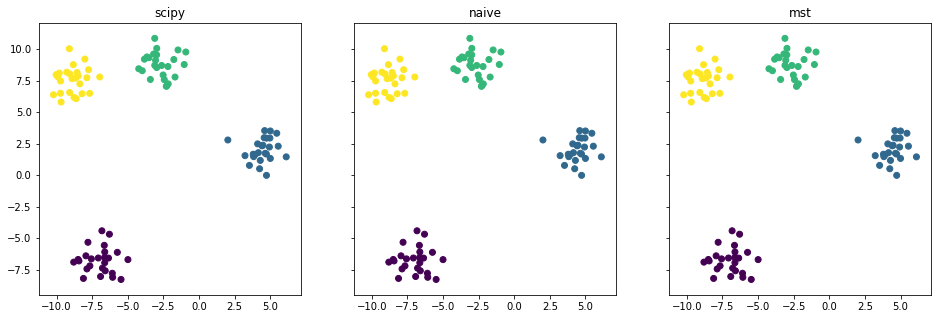

In [135]:
algo = ("scipy", "naive", "mst")

f, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16, 5))
ax[0].scatter(data[:, 0], data[:, 1], c=scipy_labels)
ax[1].scatter(data[:, 0], data[:, 1], c=naive_labels)
ax[2].scatter(data[:, 0], data[:, 1], c=mst_labels)

for i in range(3):
    ax[i].set_title(algo[i])

# Сравнение по времени работы

In [84]:
def run_time_test(models, data, n_iter):
    result = np.zeros((len(models), n_iter))
    
    for iter_ in range(n_iter):
        for idx, model in enumerate(models):
            start_time = time.time()
            _ = model.fit(data)
            end_time = time.time()
            result[idx, iter_] = end_time - start_time
            
    return result

def time_test(models):
    n_samples = (10, 100, 2000, 5000, 8000)
    results = np.zeros((2, 6))
    
    for i in tqdm_notebook(range(5)):
        data, _ = make_blobs(n_samples=n_samples[i], n_features=10, centers=4, random_state=42)
        test_time = run_time_test(models, data, 1)
        
        results[0, i] = test_time.mean(1)[0]
        results[1, i] = test_time.mean(1)[1]
        
    return results

In [85]:
models = [SingleLinkClust(0, method="naive"), 
          SingleLinkClust(0, method="mst")]

test = time_test(models)

In [93]:
n_iter = [10, 100, 2000, 5000, 8000]

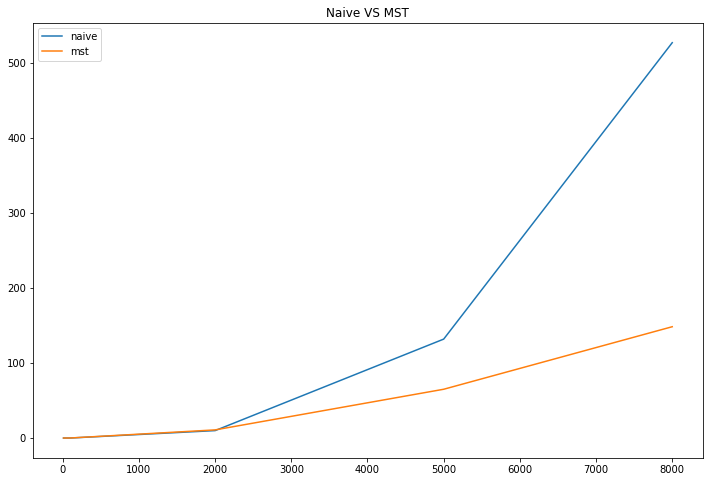

In [119]:
plt.figure(figsize=(12, 8))
plt.plot(n_iter, test[0, :5], label="naive")
plt.plot(n_iter, test[1, :5], label="mst")
plt.legend()
plt.title("Naive VS MST");

Видно, что начиная с 2к наблюдений наивный алгоритм заметно проигрывает эффективной реализации. Для 8к эта разница почти в 4 раза. 
Однако, даже эффективный алгоритм (в моей реализации конечно же) занимает слишком много времени для того, чтобы его можно было применять на практике (несмотря на то, что я старался векторизовать все вычисления). Реализация scipy намного быстрее. 

In [116]:
data, _ = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=42)
dist_matrix = pairwise_dist(data)
labels = np.arange(dist_matrix.shape[0])
cProfile.run("_mst_linkage_core(labels, dist_matrix)")

         4009 function calls in 2.648 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.647    2.647 <string>:1(<module>)
      999    0.003    0.000    0.011    0.000 fromnumeric.py:1110(argmin)
      999    0.001    0.000    0.009    0.000 fromnumeric.py:54(_wrapfunc)
        1    2.636    2.636    2.647    2.647 hierarchy.py:35(_mst_linkage_core)
        1    0.000    0.000    0.000    0.000 numeric.py:112(zeros_like)
        1    0.000    0.000    0.000    0.000 numeric.py:293(full)
        1    0.000    0.000    2.648    2.648 {built-in method builtins.exec}
      999    0.001    0.000    0.001    0.000 {built-in method builtins.getattr}
        1    0.000    0.000    0.000    0.000 {built-in method numpy.array}
        2    0.000    0.000    0.000    0.000 {built-in method numpy.copyto}
        1    0.000    0.000    0.000    0.000 {built-in method numpy.empty_like}
        1    0.000   

Здесь это особенно видно. Из всего времени, которое тратит на работу наивный алгоритм, почти секунду здесь это нахождение минимального элемента. У MST реализации такого перекоса нет.

In [114]:
cProfile.run("linkage_naive(dist_matrix)")

         10008 function calls in 1.143 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    1.143    1.143 <string>:1(<module>)
      999    0.004    0.000    0.990    0.001 fromnumeric.py:1110(argmin)
     1000    0.003    0.000    0.986    0.001 fromnumeric.py:54(_wrapfunc)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:942(argsort)
        1    0.020    0.020    1.105    1.105 hierarchy.py:16(_get_clusters_naive)
        1    0.000    0.000    1.142    1.142 hierarchy.py:7(linkage_naive)
        1    0.000    0.000    0.000    0.000 numeric.py:175(ones)
      999    0.002    0.000    0.002    0.000 union.py:10(union)
     1998    0.004    0.000    0.004    0.000 union.py:20(find)
        1    0.000    0.000    0.000    0.000 union.py:5(__init__)
        1    0.000    0.000    0.000    0.000 utils.py:25(sort_linkage)
      999    0.008    0.000    1.036    0.001 utils.py:39(nearest_

В scipy основные методы написаны на CPython, поэтому такая разница в скорости.

# Недостатки метода 

Не стал придумывать что-то сложное, достаточно посмотреть даже на простой пример с make_blobs

In [136]:
data, y = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=42)

In [137]:
mst = SingleLinkClust(method="mst")
mst.fit(data)

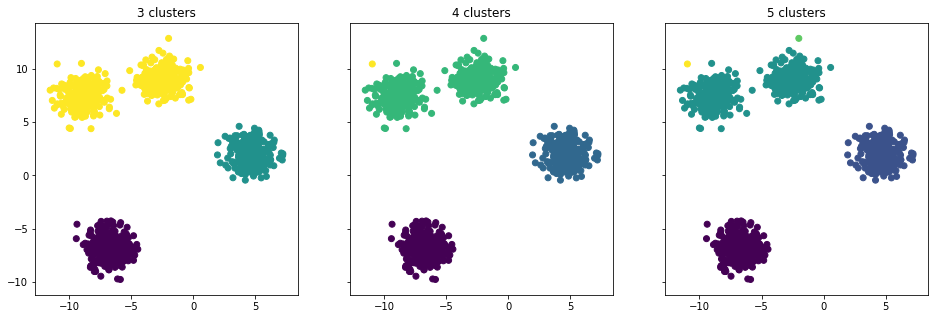

In [141]:
f, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16, 5))
ax[0].scatter(data[:, 0], data[:, 1], c=mst.predict(3))
ax[1].scatter(data[:, 0], data[:, 1], c=mst.predict(4))
ax[2].scatter(data[:, 0], data[:, 1], c=mst.predict(5))

for i in range(3):
    ax[i].set_title(f"{i + 3} clusters")

Видно, что здесь явно 4 кластера, однако какие-то точки находятся менее кучно из-за чего происходит то, что происходит. Алгоритмы основанные на плотности легко бы справились с таким, например dbscan. Поэтому single linkage чувствителен к шуму т.к слияние идет по методу ближайшего соседа. Наглядный пример на картинке.  
![clust](img/clust.png)